In [2]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.hyperopt_model import HyperoptModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr,  spearmanr,  kendalltau

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# read the data
preprocessed_data = pd.read_pickle('../data/preprocessed_science_hindex.pd')

# Create a dataframe
df = pd.DataFrame(preprocessed_data)

In [4]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test=train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 79342
Number of observations in the test data: 19836


Cross-validated scores: [ 0.77640798  0.77240131  0.76293654  0.78024672]
Average R^2 score: 0.772998137309


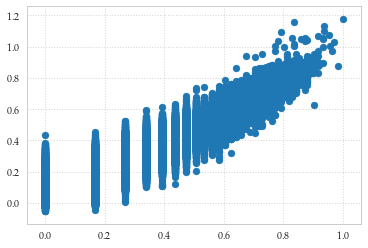

R2Score: 0.773335793392
RMSE: 0.08503123842014623


In [5]:
# Linear Regression 
dfLinear = df.copy()
y = dfLinear['score'].copy()
dfLinear.drop('score', axis=1, inplace=True) 

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(dfLinear, y, test_size=0.2)

model = linear_model.LinearRegression()

scores = cross_val_score(model, dfLinear, y, cv=4)
print("Cross-validated scores:", scores)
print("Average R^2 score:", scores.mean())

predictions = cross_val_predict(model, dfLinear, y, cv=4)
plt.scatter(y, predictions)
plt.show()

accuracy = metrics.r2_score(y, predictions)
print("R2Score:", accuracy)
rmse = sqrt(metrics.mean_squared_error(y,  predictions))
print("RMSE:", rmse)

In [6]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Lasso Regression with hyperopt optimization
    lasso = HyperoptModel(train.copy(), test.copy(),'lasso', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')

    lasso.pipeline = Pipeline([
        ('estimate', linear_model.Lasso(**{'alpha': 0.0006577184991258585}))
    ])
    
    lasso.raw_features = features
    lasso.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 10),
    }

    if hyperopt:
        lasso.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lasso.pipeline.fit(X=lasso.X_train, y=lasso.y_train)
        lasso.model = lasso.pipeline
        lasso.stats()
        lasso.plot_feature_importance()
        lasso.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        lasso.qq_plot()

Stats (train | test):
	R^2 score:		0.7632
					0.7685
	RMSE:			0.0869
					0.0858
	Mean error:		0.0707
					0.0700
	Pearson:		0.8741
					0.8773
	Spearman:		0.8197
					0.8257
	KendallTau:		0.6833
					0.6895

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [7]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Ridge Regression with hyperopt optimization
    ridge = HyperoptModel(train.copy(), test.copy(),'ridge', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')
    ridge.raw_features = features

    ridge.pipeline = Pipeline([
        ('estimate', linear_model.Ridge(**{'alpha': 0.05231780585024858}))
    ])
    
    ridge.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 1000),
    }

    if hyperopt:
        ridge.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        ridge.pipeline.fit(X=ridge.X_train, y=ridge.y_train)
        ridge.model = ridge.pipeline
        ridge.stats()
        ridge.plot_feature_importance()
        ridge.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        ridge.qq_plot()

Stats (train | test):
	R^2 score:		0.7723
					0.7781
	RMSE:			0.0853
					0.0840
	Mean error:		0.0696
					0.0688
	Pearson:		0.8788
					0.8821
	Spearman:		0.8228
					0.8291
	KendallTau:		0.6878
					0.6943

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [8]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run MLPRegressor with hyperopt optimization
    nn = HyperoptModel(train.copy(), test.copy(),'nn', cv=3, max_evals=500)
    features = list(df)
    features.remove('score')
    nn.raw_features = features

    nn.pipeline = Pipeline([
        ('estimate', MLPRegressor())
    ])
   
    nn.space = {
         'estimate__alpha' : hp.uniform('estimate__alpha', 0.001, 1),
         'estimate__activation' : hp.choice('estimate__activation', ['logistic']), # 'identity', 'logistic', 'tanh', 'relu'
         #'estimate__learning_rate' : hp.choice('estimate__learning_rate', ['constant', 'invscaling', 'adaptive']),
         'estimate__hidden_layer_sizes' : scope.int(hp.uniform('estimate__hidden_layer_sizes', 1, 100)),
         'estimate__solver' : hp.choice('estimate__solver', ['adam']), #'lbfgs', 'sgd',
         #'estimate__max_iter' : scope.int(hp.uniform('estimate__max_iter', 500, 1000))
    }

    if hyperopt:
        nn.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        nn.pipeline.fit(X=nn.X_train, y=nn.y_train)
        nn.model = cat.pipeline
        nn.stats()
        nn.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        nn.plot_feature_importance()
        nn.qq_plot()

Performing parameters optimization...
[1/500]	cv_eval_time=12.46 sec	RMSE=0.104544	R^2=0.658195
[2/500]	cv_eval_time=28.92 sec	RMSE=0.098553	R^2=0.695272
[3/500]	cv_eval_time=16.24 sec	RMSE=0.100331	R^2=0.678093
[4/500]	cv_eval_time=22.78 sec	RMSE=0.099438	R^2=0.686063
[5/500]	cv_eval_time=21.73 sec	RMSE=0.107473	R^2=0.648090
[6/500]	cv_eval_time=28.26 sec	RMSE=0.095439	R^2=0.709402
[7/500]	cv_eval_time=24.24 sec	RMSE=0.102261	R^2=0.691193
[8/500]	cv_eval_time=17.40 sec	RMSE=0.101790	R^2=0.678924
[9/500]	cv_eval_time=25.57 sec	RMSE=0.094773	R^2=0.717615
[10/500]	cv_eval_time=32.88 sec	RMSE=0.087299	R^2=0.764971
[11/500]	cv_eval_time=35.53 sec	RMSE=0.091329	R^2=0.734331
[12/500]	cv_eval_time=35.81 sec	RMSE=0.096555	R^2=0.718737
[13/500]	cv_eval_time=53.26 sec	RMSE=0.095217	R^2=0.717689
[14/500]	cv_eval_time=34.09 sec	RMSE=0.103572	R^2=0.661782
[15/500]	cv_eval_time=47.92 sec	RMSE=0.087106	R^2=0.762236
[16/500]	cv_eval_time=57.59 sec	RMSE=0.092858	R^2=0.734625
[17/500]	cv_eval_time=38.00

[139/500]	cv_eval_time=32.60 sec	RMSE=0.096499	R^2=0.707481
[140/500]	cv_eval_time=40.49 sec	RMSE=0.105513	R^2=0.651897
[141/500]	cv_eval_time=52.78 sec	RMSE=0.089123	R^2=0.752272
[142/500]	cv_eval_time=37.96 sec	RMSE=0.088504	R^2=0.756391
[143/500]	cv_eval_time=27.52 sec	RMSE=0.105671	R^2=0.645656
[144/500]	cv_eval_time=48.21 sec	RMSE=0.091468	R^2=0.740146
[145/500]	cv_eval_time=27.10 sec	RMSE=0.103907	R^2=0.667921
[146/500]	cv_eval_time=39.73 sec	RMSE=0.086666	R^2=0.766432
[147/500]	cv_eval_time=51.08 sec	RMSE=0.087610	R^2=0.760836
[148/500]	cv_eval_time=33.52 sec	RMSE=0.086573	R^2=0.767905
[149/500]	cv_eval_time=54.88 sec	RMSE=0.087128	R^2=0.764605
[150/500]	cv_eval_time=39.59 sec	RMSE=0.086615	R^2=0.764672
[151/500]	cv_eval_time=59.34 sec	RMSE=0.087052	R^2=0.761335
[152/500]	cv_eval_time=52.49 sec	RMSE=0.086481	R^2=0.760195
[153/500]	cv_eval_time=49.27 sec	RMSE=0.088692	R^2=0.752412
[154/500]	cv_eval_time=55.75 sec	RMSE=0.086688	R^2=0.762565
[155/500]	cv_eval_time=52.62 sec	RMSE=0.

[276/500]	cv_eval_time=332.82 sec	RMSE=0.089402	R^2=0.752740
[277/500]	cv_eval_time=355.03 sec	RMSE=0.088961	R^2=0.754590
[278/500]	cv_eval_time=355.73 sec	RMSE=0.087059	R^2=0.765194
[279/500]	cv_eval_time=304.51 sec	RMSE=0.086572	R^2=0.762661
[280/500]	cv_eval_time=199.20 sec	RMSE=0.089881	R^2=0.745790
[281/500]	cv_eval_time=360.55 sec	RMSE=0.087889	R^2=0.758102
[282/500]	cv_eval_time=334.01 sec	RMSE=0.087150	R^2=0.762547
[283/500]	cv_eval_time=250.16 sec	RMSE=0.086488	R^2=0.764130
[284/500]	cv_eval_time=283.68 sec	RMSE=0.088238	R^2=0.755408
[285/500]	cv_eval_time=208.54 sec	RMSE=0.105516	R^2=0.649004
[286/500]	cv_eval_time=379.35 sec	RMSE=0.086413	R^2=0.765595
[287/500]	cv_eval_time=63.69 sec	RMSE=0.099263	R^2=0.690204
[288/500]	cv_eval_time=85.72 sec	RMSE=0.090582	R^2=0.744568
[289/500]	cv_eval_time=106.40 sec	RMSE=0.087805	R^2=0.749791
[290/500]	cv_eval_time=68.19 sec	RMSE=0.088546	R^2=0.755259
[291/500]	cv_eval_time=43.79 sec	RMSE=0.086604	R^2=0.764250
[292/500]	cv_eval_time=111.0

[412/500]	cv_eval_time=107.77 sec	RMSE=0.088696	R^2=0.757887
[413/500]	cv_eval_time=65.58 sec	RMSE=0.087231	R^2=0.759494
[414/500]	cv_eval_time=80.96 sec	RMSE=0.087088	R^2=0.762859
[415/500]	cv_eval_time=101.49 sec	RMSE=0.087389	R^2=0.762717
[416/500]	cv_eval_time=70.54 sec	RMSE=0.086911	R^2=0.768127
[417/500]	cv_eval_time=57.78 sec	RMSE=0.086244	R^2=0.765941
[418/500]	cv_eval_time=64.10 sec	RMSE=0.087712	R^2=0.750668
[419/500]	cv_eval_time=105.65 sec	RMSE=0.086695	R^2=0.763469
[420/500]	cv_eval_time=97.74 sec	RMSE=0.086535	R^2=0.764748
[421/500]	cv_eval_time=60.00 sec	RMSE=0.087291	R^2=0.760713
[422/500]	cv_eval_time=70.04 sec	RMSE=0.086367	R^2=0.764895
[423/500]	cv_eval_time=110.49 sec	RMSE=0.087118	R^2=0.761492
[424/500]	cv_eval_time=66.55 sec	RMSE=0.086300	R^2=0.765981
[425/500]	cv_eval_time=66.90 sec	RMSE=0.087178	R^2=0.757838
[426/500]	cv_eval_time=51.98 sec	RMSE=0.087616	R^2=0.760903
[427/500]	cv_eval_time=67.63 sec	RMSE=0.088254	R^2=0.754221
[428/500]	cv_eval_time=95.17 sec	RMS

In [9]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run CatBoostRegressor with hyperopt optimization
    cat = HyperoptModel(train.copy(), test.copy(),'cat', cv=3, max_evals = 30)

    cat.pipeline = Pipeline([
        ('estimate', CatBoostRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    cat.raw_features = features
    
    cat.space = {
        'estimate__iterations': hp.choice('estimate__iterations', [1300]),
        'estimate__loss_function': hp.choice('estimate__loss_function', ['RMSE']),
        'estimate__train_dir': hp.choice('estimate__train_dir', ['outputs/cat']),
        'estimate__thread_count': hp.choice('estimate__thread_count', [4]),
        'estimate__used_ram_limit': hp.choice('estimate__used_ram_limit', [1024 * 1024 * 1024 * 4]),  # 4gb
        'estimate__random_seed': hp.choice('estimate__random_seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -5, 0),
        'estimate__random_strength': hp.choice('estimate__random_strength', [1, 20]),
        'estimate__l2_leaf_reg': hp.loguniform('estimate__l2_leaf_reg', 0, np.log(10)),
        'estimate__bagging_temperature': hp.uniform('estimate__bagging_temperature', 0, 1),
    }

    """
    find the best number of trees (following https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning_trees-number-docpage/#parameter-tuning_trees-number)
    need to also substitute the CatBoostRegressor parameters with:
        ('estimate', CatBoostRegressor(iterations=10000, loss_function='RMSE', auto_stop_pval=1e-4, use_best_model=True, train_dir='outputs/cat_trees', verbose=True))
    """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # eval_X = cat.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # cat.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set)
    # cat.model = cat.pipeline
    # print(cat.model.named_steps['estimate'].get_params())
    # cat.model.named_steps['estimate'].save_model('tmp/cat.model'.encode('utf-8'))

    if hyperopt:
        cat.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        cat.pipeline.fit(X=cat.X_train, y=cat.y_train)
        cat.model = cat.pipeline
        cat.stats()
        cat.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        cat.plot_feature_importance()
        #cat.qq_plot()

Performing parameters optimization...
[1/30]	cv_eval_time=1172.40 sec	RMSE=0.070170	R^2=0.845382
[2/30]	cv_eval_time=1203.62 sec	RMSE=0.071026	R^2=0.841381
[3/30]	cv_eval_time=1182.72 sec	RMSE=0.084751	R^2=0.775228
[4/30]	cv_eval_time=1230.56 sec	RMSE=0.070376	R^2=0.845171
[5/30]	cv_eval_time=1189.75 sec	RMSE=0.070168	R^2=0.846711
[6/30]	cv_eval_time=1232.30 sec	RMSE=0.071422	R^2=0.840325
[7/30]	cv_eval_time=1191.03 sec	RMSE=0.073211	R^2=0.832627
[8/30]	cv_eval_time=1216.59 sec	RMSE=0.071724	R^2=0.839087
[9/30]	cv_eval_time=1190.64 sec	RMSE=0.071599	R^2=0.839329
[10/30]	cv_eval_time=1378.53 sec	RMSE=0.070300	R^2=0.845049
[11/30]	cv_eval_time=1632.22 sec	RMSE=0.070721	R^2=0.843165
[12/30]	cv_eval_time=1641.22 sec	RMSE=0.070074	R^2=0.846252
[13/30]	cv_eval_time=1604.31 sec	RMSE=0.070998	R^2=0.843103
[14/30]	cv_eval_time=1682.21 sec	RMSE=0.074459	R^2=0.827583
[15/30]	cv_eval_time=1597.11 sec	RMSE=0.074379	R^2=0.826435
[16/30]	cv_eval_time=1664.03 sec	RMSE=0.069960	R^2=0.846330
[17/30]	cv_

In [10]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run LGBMRegressor with hyperopt optimization
    lgbm = HyperoptModel(train.copy(), test.copy(), 'lgbm', cv=3, max_evals=50)
    lgbm.pipeline = Pipeline([
        ('estimate', lgb.LGBMRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    lgbm.raw_features = features
   
    """ find number of trees """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # eval_X = lgbm.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # best = lgbm.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set, estimate__early_stopping_rounds=10)
    # print(best.named_steps['estimate'].best_iteration)

    lgbm.space = {
        'estimate__objective': hp.choice('estimate__objective', ['regression']),
        'estimate__n_estimators': hp.choice('estimate__n_estimators', [400]),
        'estimate__seed': hp.choice('estimate__seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -7, 0),
        'estimate__num_leaves': scope.int(hp.qloguniform('estimate__num_leaves', 1, 7, 1)),
        'estimate__feature_fraction': hp.uniform('estimate__feature_fraction', 0.5, 1),
        'estimate__bagging_fraction': hp.uniform('estimate__bagging_fraction', 0.5, 1),
        'estimate__min_data_in_leaf': scope.int(hp.qloguniform('estimate__min_data_in_leaf', 0, 6, 1)),
        'estimate__min_sum_hessian_in_leaf': hp.loguniform('estimate__min_sum_hessian_in_leaf', -16, 5),
        'estimate__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('estimate__lambda_l1_positive', -16, 2)]),
        'estimate__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('estimate__lambda_l2_positive', -16, 2)]),
    }

    if hyperopt:
        lgbm.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lgbm.pipeline.fit(X=lgbm.X_train, y=lgbm.y_train)
        lgbm.model = lgbm.pipeline
        lgbm.stats()
        lgbm.plot_predicted_vs_actual()
        lgbm.plot_feature_importance()

Performing parameters optimization...
[1/50]	cv_eval_time=821.33 sec	RMSE=0.071432	R^2=0.840083
[2/50]	cv_eval_time=80.91 sec	RMSE=0.082811	R^2=0.786371
[3/50]	cv_eval_time=138.85 sec	RMSE=0.072517	R^2=0.835134
[4/50]	cv_eval_time=41.88 sec	RMSE=0.071924	R^2=0.838591
[5/50]	cv_eval_time=115.08 sec	RMSE=0.070191	R^2=0.845427
[6/50]	cv_eval_time=86.18 sec	RMSE=0.074320	R^2=0.827211
[7/50]	cv_eval_time=574.91 sec	RMSE=0.072810	R^2=0.833760
[8/50]	cv_eval_time=22.83 sec	RMSE=0.079361	R^2=0.802663
[9/50]	cv_eval_time=336.15 sec	RMSE=0.069728	R^2=0.847696
[10/50]	cv_eval_time=735.68 sec	RMSE=0.081348	R^2=0.792695
[11/50]	cv_eval_time=120.40 sec	RMSE=0.070733	R^2=0.843778
[12/50]	cv_eval_time=47.52 sec	RMSE=0.090272	R^2=0.744627
[13/50]	cv_eval_time=1706.16 sec	RMSE=0.068417	R^2=0.853363
[14/50]	cv_eval_time=998.21 sec	RMSE=0.122593	R^2=0.529101
[15/50]	cv_eval_time=32.07 sec	RMSE=0.071753	R^2=0.838615
[16/50]	cv_eval_time=269.51 sec	RMSE=0.069332	R^2=0.849283
[17/50]	cv_eval_time=17.37 sec	R

In [ ]:
    #Polynomial linear regression 
    degrees = 4
    for d in range(1, degrees+1):
            print("Degree: %s" % d)
            # Create the model, split the sets and fit it
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = linear_model.LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            dfPoly = df.copy()
            y = dfPoly['score'].copy()
            dfPoly.drop('score', axis=1, inplace=True) 

            # create training and testing vars
            X_train, X_test, y_train, y_test = train_test_split(dfPoly, y, test_size=0.2)

            model.fit(X_train, y_train)
            # Calculate the metrics
            train_prediction = model.predict(X_train)
            test_prediction = model.predict(X_test)
            
            print('Polynomial degree: {}'.format(d))
            print('Stats (train | test):')
            print('\tR^2 score:\t\t%.4f\n\t\t\t\t\t%.4f' % (r2_score(y_train, train_prediction),
                                                        r2_score(y_test, test_prediction)))
            print('\tRMSE:\t\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_squared_error(y_train, train_prediction) ** 0.5,
                                                     mean_squared_error(y_test, test_prediction) ** 0.5))
            print('\tMean error:\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_absolute_error(y_train, train_prediction),
                                                         mean_absolute_error(y_test, test_prediction)))
            print('\tPearson:\t\t%.4f\n\t\t\t\t\t%.4f' % (pearsonr(y_train, train_prediction)[0],
                                                         pearsonr(y_test, test_prediction)[0]))
            print('\tSpearman:\t\t%.4f\n\t\t\t\t\t%.4f' % (spearmanr(y_train, train_prediction)[0],
                                                         spearmanr(y_test, test_prediction)[0]))
            print('\tKendallTau:\t\t%.4f\n\t\t\t\t\t%.4f' % (kendalltau(y_train, train_prediction)[0],
                                                         kendalltau(y_test, test_prediction)[0]))

Degree: 1
Polynomial degree: 1
Stats (train | test):
	R^2 score:		0.7715
					0.7812
	RMSE:			0.0852
					0.0841
	Mean error:		0.0697
					0.0687
	Pearson:		0.8784
					0.8839
	Spearman:		0.8225
					0.8309
	KendallTau:		0.6873
					0.6965
Degree: 2
Polynomial degree: 2
Stats (train | test):
	R^2 score:		0.8004
					0.7942
	RMSE:			0.0799
					0.0805
	Mean error:		0.0655
					0.0656
	Pearson:		0.8947
					0.8912
	Spearman:		0.8410
					0.8376
	KendallTau:		0.7111
					0.7077
Degree: 3
